# Introduction

* Contributors:
    * Diptarko Choudhury
        * Int. MSc (Physics) student at NISER Bhubaneshwar, HBNI
        * Links: [GitHub](https://github.com/dc250601), [Email](mailto:diptarko.choudhury@niser.ac.in)
    * Aritra Mukhopadhay
        * Int. MSc (Physics) student at NISER Bhubaneshwar, HBNI
        * Links: [GitHub](https://github.com/PeithonKing), [Email](mailto:aritra.mukhopadhyay@niser.ac.in), [Linkedin](https://www.linkedin.com/in/aritra-mukhopadhyay-212172224/)

* **Abstract:** We are trying to detect higgs boson using machine learning techniques. The data set consists of 11 Million data points and there are 28 features in total out of which 21 are low level features and rest are high level features. The data is generated by Monte Carlo Simulation.

### We focussed on building an ensemble model which consisted of 5 neural network architectures and 1 XGBoost architecture. The entire model was trained in parts on a single 1060ti 6gb Graphics card. The net ROC-AUC obtained as around 0.88. The data was split into test and training of which the training set consisted of first 10 Million data points and the rest was given to the test set

* To go to the Github Repository, [click here](https://github.com/PeithonKing/ML_comp/tree/main/Higgs)

# Initialisation 

In [1]:
!pip install XGBoost==1.5.0
# ~23s

     |████████████████████████████████| 173.5 MB 57 kB/s 
  Attempting uninstall: XGBoost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [2]:
from json import load, dump
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn import metrics
import xgboost as xgb
import tensorflow as tf
from gc import collect
import pandas as pd
import os
from time import time
from gc import collect as delete
# 2s

In [3]:
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz"
# 1.5 min

--2021-11-30 04:07:51--  https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2816407858 (2.6G) [application/x-httpd-php]
Saving to: ‘HIGGS.csv.gz’

HIGGS.csv.gz        100%[===================>]   2.62G  43.4MB/s    in 61s     

2021-11-30 04:08:53 (43.7 MB/s) - ‘HIGGS.csv.gz’ saved [2816407858/2816407858]



In [4]:
!wget --no-check-certificate -r "https://docs.google.com/uc?export=download&id=1RlvdtcHKFu8RQ5Tv7IAhRDeGBW3QNwOH" -O "Weights.zip"
# 3s

will be placed in the single file you specified.

--2021-11-30 04:08:53--  https://docs.google.com/uc?export=download&id=1RlvdtcHKFu8RQ5Tv7IAhRDeGBW3QNwOH
Resolving docs.google.com (docs.google.com)... 74.125.31.138, 74.125.31.100, 74.125.31.101, ...
Connecting to docs.google.com (docs.google.com)|74.125.31.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘Weights.zip’

Weights.zip             [ <=>                ]   3.19K  --.-KB/s    in 0s      

2021-11-30 04:08:53 (24.6 MB/s) - ‘Weights.zip’ saved [3270]

Loading robots.txt; please ignore errors.
--2021-11-30 04:08:53--  https://docs.google.com/robots.txt
Reusing existing connection to docs.google.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘Weights.zip’

Weights.zip             [ <=>                ]     567  --.-KB/s    in 0s      

2021-11-30 04:08:53 (106 MB/s) - ‘Weights.zip’ saved [567]

--2021-11-30 04:08:

In [5]:
!wget --no-check-certificate -r "https://docs.google.com/uc?export=download&id=1eFDnAn-MhhK4uE2QwSwDJgdEz-z9pyL3" -O "history.json"
# 1s

will be placed in the single file you specified.

--2021-11-30 04:08:57--  https://docs.google.com/uc?export=download&id=1eFDnAn-MhhK4uE2QwSwDJgdEz-z9pyL3
Resolving docs.google.com (docs.google.com)... 74.125.31.138, 74.125.31.100, 74.125.31.101, ...
Connecting to docs.google.com (docs.google.com)|74.125.31.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-c8-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/r35sjg4a36jrj1plogl1ejjina9bggav/1638245325000/17182296012637223398/*/1eFDnAn-MhhK4uE2QwSwDJgdEz-z9pyL3?e=download [following]
--2021-11-30 04:08:58--  https://doc-04-c8-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/r35sjg4a36jrj1plogl1ejjina9bggav/1638245325000/17182296012637223398/*/1eFDnAn-MhhK4uE2QwSwDJgdEz-z9pyL3?e=download
Resolving doc-04-c8-docs.googleusercontent.com (doc-04-c8-docs.googleusercontent.com)... 64.233.170.132, 2607:f8b0:400c:c0d::84
Connecting to doc

In [6]:
!gzip -d HIGGS.csv.gz
# 3min

In [7]:
!unzip Weights.zip
# 10s

Archive:  Weights.zip
warning [Weights.zip]:  358519 extra bytes at beginning or within zipfile
  (attempting to process anyway)
   creating: NN_Shallow_10240/
  inflating: NN_Shallow_10240/saved_model.pb  
   creating: NN_Shallow_10240/variables/
  inflating: NN_Shallow_10240/variables/variables.data-00000-of-00001  
  inflating: NN_Shallow_10240/variables/variables.index  
   creating: ResNet_52/
  inflating: ResNet_52/keras_metadata.pb  
  inflating: ResNet_52/saved_model.pb  
   creating: ResNet_52/variables/
  inflating: ResNet_52/variables/variables.data-00000-of-00001  
  inflating: ResNet_52/variables/variables.index  
  inflating: XGBoost.json            
   creating: DNN_5/
  inflating: DNN_5/saved_model.pb    
   creating: DNN_5/variables/
  inflating: DNN_5/variables/variables.data-00000-of-00001  
  inflating: DNN_5/variables/variables.index  
   creating: NN_Shallow_1024/
  inflating: NN_Shallow_1024/saved_model.pb  
   creating: NN_Shallow_1024/variables/
  inflating: NN

# Refining the data

In [8]:
def refine_data():
    # Step 1: 
    df = pd.read_csv("HIGGS.csv", header = None)

    data_set = np.array(df.iloc[:, 1:])
    label_set = np.array(df.iloc[:, 0])

    # Getting rid of unnecessary data from RAM to
    # accomodate within the 12GB RAM provided by Colab
    del df
    delete()

    data_set = np.round(data_set, 5)

    data_set = data_set.astype(np.float32)
    label_set = label_set.astype(np.int32)

    df_data_set = pd.DataFrame(data_set)
    df_label_set = pd.DataFrame(label_set)

    s = df_data_set.min()
    l = df_data_set.max()

    # Step 2: Normalization
    normed_df_Data_set = ((df_data_set - s) / (l - s)).astype(np.float32)

    # Saving data to file
    df_label_set.to_csv("LabelSet.csv")
    normed_df_Data_set.to_csv("DataSetNormalised.csv")

# All the Models
## * These are the functions only.

There are 6 models in our machine Learning Pipeline. We have put them in functions and the functions are here. We didn't call them here. they will be called later.

#### Deep Neural Network DNN5 

In [9]:
def DNN5_fc():
    '''Deep Neural Network DNN5'''
    model=tf.keras.Sequential([
        tf.keras.layers.Dense(300, input_shape=(28,), activation='swish'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(300, activation='swish'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(300, activation='swish'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(300, activation='swish'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(300, activation='swish'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer = tf.keras.optimizers.Adam(
        learning_rate = 0.01,
        beta_1 = 0.9,
        beta_2 = 0.999),
        loss = 'binary_crossentropy',
        metrics = ['accuracy','AUC']
        )
    model.fit(
        x_train,
        y_train,
        epochs=1,
        batch_size=10240,
        validation_data=(x_test,y_test)
    )
    model.save('DNN_5')

#### Resnet 52 custom model

In [10]:
def identity_block(X, no_nodes, Activation):
    '''A custom Residual identity block with a skip connection'''
    # This function is not to be called manually, it will be used by RN52_fc() function
    X_shortcut=X
    # There will be 3 layers in total for the sequential connection
    # Activation will be specified by the user as per the Keras Documentation
    # no_nodes denote the size of the model which will be built
    # Applying Batch Normalisation to size the inputs
    
    #Layer 1
    X=tf.keras.layers.Dense(no_nodes,activation=Activation)(X)
    X=tf.keras.layers.BatchNormalization(axis=1)(X)
    X=tf.keras.layers.Dropout(d_rate)(X)

    #Layer 2
    X=tf.keras.layers.Dense(no_nodes,activation=Activation)(X)
    X=tf.keras.layers.BatchNormalization(axis=1)(X)
    X=tf.keras.layers.Dropout(d_rate)(X)

    #Layer 3
    X=tf.keras.layers.Dense(no_nodes,activation=Activation)(X)
    X=tf.keras.layers.Dropout(d_rate)(X)

    #Layer 4
    X= tf.keras.layers.Add()([X_shortcut, X])
    X=tf.keras.layers.Activation('relu')(X)

    X_shortcut2=X
    #Layer 5
    X=tf.keras.layers.Dense(no_nodes,activation=Activation)(X)
    X=tf.keras.layers.BatchNormalization(axis=1)(X)
    X=tf.keras.layers.Dropout(d_rate)(X)

    #Layer 6
    X=tf.keras.layers.Dense(no_nodes,activation=Activation)(X)
    X=tf.keras.layers.BatchNormalization(axis=1)(X)
    X=tf.keras.layers.Dropout(d_rate)(X)

    #Layer 7
    X=tf.keras.layers.Dense(no_nodes,activation=Activation)(X)
    X=tf.keras.layers.Dropout(d_rate)(X)

    #Layer 8
    X = tf.keras.layers.Add()([X_shortcut, X,X_shortcut2])
    X = tf.keras.layers.Activation('relu')(X)
    return X

def RN52_fc():
    '''Resnet 52'''
    d_rate=0.1 #The rate of droupout for the layers in the ResNet
    act='gelu'#The activation function use ('relu','swish','elu','gelu','selu')
    lr=0.01 #The default learning rate Default 0.01
    mom=0.9 #The momentum parameter Default 0.9
    test_split=1 #Default 1 and range[1,0)
    #Reducing test_split will make the model faster but will also reduce the accuracy of the Validation metric
    #On changing test_split run the lower initialisation cell, marked below**
    
    inputs=tf.keras.layers.Input(shape=(28,))                   # Keras input layer
    X=tf.keras.layers.Dense(300,activation=act)(inputs)
    X=identity_block(X=X,no_nodes=300,Activation=act)
    X=identity_block(X=X,no_nodes=300,Activation=act)
    X=identity_block(X=X,no_nodes=300,Activation=act)
    X=identity_block(X=X,no_nodes=300,Activation=act)
    X=identity_block(X=X,no_nodes=300,Activation=act)        
    outputs=tf.keras.layers.Dense(1,activation='sigmoid')(X)    # Keras output layer
    model=tf.keras.Model(inputs,outputs)                        # Model declaration
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.01,
        beta_1=mom,
        beta_2=0.999),
        loss='binary_crossentropy',
        metrics=['accuracy','AUC']
    )
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy",
                                                 factor=0.5,
                                                 patience=5,
                                                 min_lr=10**-6,
                                                 cooldown=5,
                                                 verbose = True)

    history = History()

    model.fit(
        x_train,
        y_train,
        epochs=100,
        batch_size=20000,
        validation_data=(x_test,y_test),
        callbacks=[cp_callback, reduce_lr, history]
    )
    model.save('ResNet_52')

    with open("hstory.json", "w") as f:
        json.dump(f, history.history)

#### XG Boost

In [11]:
def XGB_fc():
    '''XG Boost'''
    model = XGBClassifier(tree_method='gpu_hist',
                          booster = 'gbtree',
                          max_depth = 14,
                          n_estimators = 300,
                          learning_rate = 0.4,
                          reg_lambda=600
                         )

    eval_set = [(x_test_alpha, y_test_alpha)]

    t0 = time()
    a = model.fit(x_train_alpha,
              y_train_alpha,
              eval_metric="error",
              eval_set=eval_set,
              verbose=True)
    taken = time()-t0

    y_test_alpha_pred = model.predict(x_test_alpha,ntree_limit=model.best_ntree_limit)
    accuracy_test = accuracy_score(y_test_alpha, y_test_alpha_pred)
    print("The testing accuracy", accuracy_test*100)

    y_train_alpha_pred=model.predict(x_train_alpha,ntree_limit=model.best_ntree_limit)
    accuracy_train = accuracy_score(y_train_alpha, y_train_alpha_pred)
    print("The training accuracy", accuracy_train*100)
    model.save_model("XGBoost.json")

#### Shallow Neural Network 1024 levels deep

In [12]:
def S1024_fc():
    model=tf.keras.Sequential([
        tf.keras.layers.Dense(1024,input_shape=(28,),activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1024,activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128,activation='swish'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1,activation='sigmoid')
        ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.0001,
        beta_1=0.9,
        beta_2=0.999),
        loss='binary_crossentropy',
        metrics=['accuracy','AUC']
        )
    
    model.fit(
        x_train,
        y_train,
        epochs=100,
        batch_size=10240,
        validation_data=(x_test,y_test),
        callbacks=[cp_callback]
        )
    
    model.save('NN_Shallow_1024')

#### Shallow Neural Network 2048 levels deep

In [13]:
def S1024_fc():
    model=tf.keras.Sequential([
        tf.keras.layers.Dense(1024,input_shape=(28,),activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1024,activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128,activation='swish'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1,activation='sigmoid')
        ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.0001,
        beta_1=0.9,
        beta_2=0.999),
        loss='binary_crossentropy',
        metrics=['accuracy','AUC']
        )
    
    model.fit(
        x_train,
        y_train,
        epochs=100,
        batch_size=10240,
        validation_data=(x_test,y_test),
        callbacks=[cp_callback]
        )
    
    model.save('NN_Shallow_1024')

#### Shallow Neural Network 10240 levels deep

In [14]:
def S10240_fc():
    model=tf.keras.Sequential([
    tf.keras.layers.Dense(10240,input_shape=(28,),activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1,activation='sigmoid')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
                            learning_rate=0.001,
                            beta_1=0.9,
                            beta_2=0.999),
        loss='binary_crossentropy',
        metrics=['accuracy','AUC']
    )
    
    model.fit(
        x_train,
        y_train,
        epochs=10,
        batch_size=10240,
        callbacks=[cp_callback]
    )

    model.save('NN_Shallow_2048')

# Ensemble (function only)

In [15]:
def ens_fc(x_test):
    print("starting")
    # Loading the models:
    #    XG Boost
    model_xgb = XGBClassifier()
    model_xgb.load_model("XGBoost.json")
    y_test_pred_xgb = model_xgb.predict_proba(x_test)
    y_pred_xgb = y_test_pred_xgb[:,1]
    y_test_pred_xgb = np.reshape(y_pred_xgb,(1_00_000,1))
    print("\n\n1.1 Loaded XGBoost\n\n")

    #    DNN 5
    model_DNN_5 = tf.keras.models.load_model('DNN_5')
    y_test_pred_DNN_5 = model_DNN_5.predict(x_test)
    print("\n\n2.1 Loaded DNN 5\n\n")

    #    Shallow 1024
    model_NN_Shallow_1024 = tf.keras.models.load_model('NN_Shallow_1024')
    y_test_pred_NN_Shallow_1024 = model_NN_Shallow_1024.predict(x_test)
    print("\n\n3.1 Loaded Shallow 1024\n\n")

    #    Shallow 2048
    model_NN_Shallow_2048 = tf.keras.models.load_model('NN_Shallow_2048')
    y_test_pred_NN_Shallow_2048 = model_NN_Shallow_2048.predict(x_test)
    print("\n\n4.1 Loaded Shallow 2048\n\n")

    #    Shallow 10240
    model_NN_Shallow_10240 = tf.keras.models.load_model('NN_Shallow_10240')
    y_test_pred_NN_Shallow_10240 = model_NN_Shallow_10240.predict(x_test)
    print("\n\n5.1 Loaded Shallow 10240\n\n")

    #    ResNet 52
    model_ResNet_52 = tf.keras.models.load_model('ResNet_52')
    y_test_pred_model_ResNet_52 = model_ResNet_52.predict(x_test)
    print("\n\n6.1 Loaded ResNet 52\n\n")


    # # The below code is used to find the fine-tuned values for ensembling all the models
    # for i in range(10000):
    #     pre=(np.random.rand(6,1))
    #     y_pred_ensemble=y_test_pred_DNN_5*pre[0]
    #     y_pred_ensemble=y_pred_ensemble+y_test_pred_model_ResNet_52*pre[1]
    #     y_pred_ensemble=y_pred_ensemble+y_test_pred_NN_Shallow_1024*pre[2]
    #     y_pred_ensemble=y_pred_ensemble+y_test_pred_NN_Shallow_10240*pre[3]
    #     y_pred_ensemble=y_pred_ensemble+y_test_pred_NN_Shallow_2048*pre[4]
    #     y_pred_ensemble=y_pred_ensemble+y_test_pred_xgb*pre[5]
    #     y_pred_ensemble=y_pred_ensemble/(pre[0]+pre[1]+pre[2]+pre[3]+pre[4]+pre[5])
    #     fpr, tpr, thresholds = roc_curve(y_test, y_pred_ensemble)
    #     auc=metrics.auc(fpr, tpr)
    #     if auc>auc_max:
    #         auc_max=auc
    #         print("New Max detected")
    #         print("Auc",auc)
    #         print("--------------------------------------------")
    #         pre_max=pre
    #     if i%1000==0:
    #         print(str(i))

    pre = (0.9874, 0.5109, 0.4046, 0.00178, 0.18467, 0.17939) # Calculated by finetuning

    y_pred_ensemble = y_test_pred_DNN_5*pre[0]
    print("1.2 Added XGBoost")
    y_pred_ensemble += y_test_pred_model_ResNet_52*pre[1]
    print("2.2 Added DNN 5")
    y_pred_ensemble += y_test_pred_NN_Shallow_1024*pre[2]
    print("3.2 Added Shallow 1024")
    y_pred_ensemble += y_test_pred_NN_Shallow_10240*pre[3]
    print("4.2 Added Shallow 2048")
    y_pred_ensemble += y_test_pred_NN_Shallow_2048*pre[4]
    print("5.2 Added Shallow 10240")
    y_pred_ensemble += y_test_pred_xgb*pre[5]
    print("6.2 Added ResNet 52")

    y_pred_ensemble /= sum(pre)
    # ntgt() # Used for fine tuning of model, @Aritra don't uncomment it
    return y_pred_ensemble

# Calling the functions Sequentially

In [16]:
# Refining the data!
refine_data()
# 10min

In [17]:
# Importing the dataset
df_data = pd.read_csv("DataSetNormalised.csv")
df_label = pd.read_csv("LabelSet.csv")
# 1min

In [18]:
# Separating the data
x = np.array(df_data.iloc[:,1:])
y = np.array(df_label.iloc[:,1])
x = x.astype(np.float32)
x_train = x[:][:1_00_00_000]
y_train = y[:][:1_00_00_000]
x_test = x[:][-1_00_000:]
y_test = y[:][-1_00_000:]
# 4s

In [ ]:
# # Calling the models for training
# #       This has been intensionally commented out because
# #       we have already trained them and downloaded the weights
# #       from Google Drive.(See Initialization part.)
# #       Note: As you are not running this block, the next block
# #             will throw a number of warnings, please ignore them!
# DNN5_fc()
# RN52_fc()
# XGB_fc()
# S1024_fc()
# S2048_fc()
# S10240_fc()

In [19]:
# Caling the ensemble
# Send the data set X (After normalisation min-max)
# keep y_test as the testing data set
y_pred = ens_fc(x_test) # takes around 3 minutes

starting


1.1 Loaded XGBoost






2.1 Loaded DNN 5






3.1 Loaded Shallow 1024






4.1 Loaded Shallow 2048






5.1 Loaded Shallow 10240




6.1 Loaded ResNet 52


1.2 Added XGBoost
2.2 Added DNN 5
3.2 Added Shallow 1024
4.2 Added Shallow 2048
5.2 Added Shallow 10240
6.2 Added ResNet 52


# Finally Some Nice looking Curves

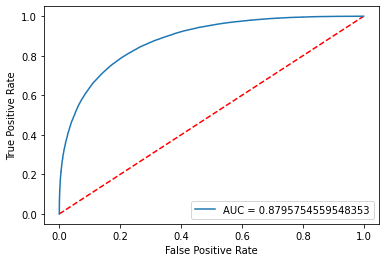

In [20]:
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
auc = metrics.roc_auc_score(y_test, y_pred)

# Straight Line
plt.plot([0,1], [0,1], "r--")

#create ROC curve
plt.plot(fpr, tpr, label = f"AUC = {auc}")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [21]:
with open("history.json") as f: data = load(f)

In [22]:
data.keys()

dict_keys(['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc', 'lr'])

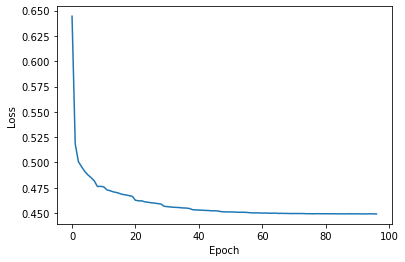

In [23]:
plt.plot(data["loss"])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

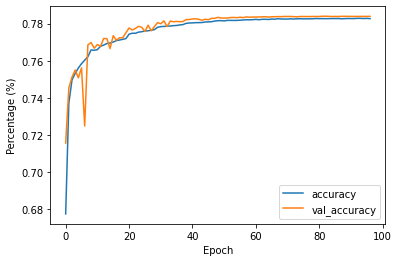

In [24]:
plt.plot(data["accuracy"], label = "accuracy")
plt.plot(data["val_accuracy"], label = "val_accuracy")
plt.ylabel('Percentage (%)')
plt.xlabel('Epoch')
plt.legend(loc=4)
plt.show()

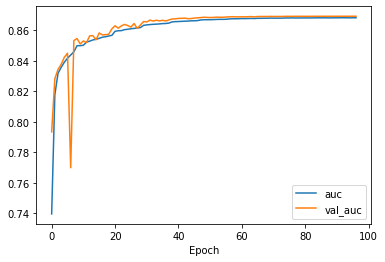

In [25]:
plt.plot(data["auc"], label = "auc")
plt.plot(data["val_auc"], label = "val_auc")
# plt.ylabel('Percentage (%)')
plt.xlabel('Epoch')
plt.legend(loc=4)
plt.show()

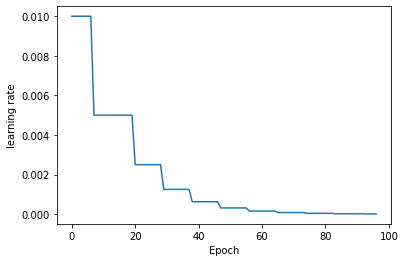

In [26]:
plt.plot(data["lr"])
plt.ylabel('learning rate')
plt.xlabel('Epoch')
plt.show()

### "val_loss" could not be plotted because it did not have any good value for some bug in tensorflow!

## **Appologies:**
* We didn't record the data for all the models. We only have data for the XG Boost model. But if you want proof that we really trained this model, you can [click here](https://github.com/PeithonKing/ML_comp/tree/main/Higgs) and view our github repository. 
* Actually we didn't train in this colab file. We trained it all using separate jupyter notebooks. All those notebooks are there in GitHub. At the end we made this file, put all the relevant codes in the form of functions and submitted it as a single file.

Thank You,\
Aritra and Diptarko
